ОБУЧЕНИЕ

In [2]:
pip install ultralytics torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00


In [3]:

import torch
import os
import shutil
import zipfile
from IPython.display import Image, display
import matplotlib.pyplot as plt
import yaml
from ultralytics import YOLO
import numpy as np
import pandas as pd

zip_path = 'YOLODataset.zip'
dataset_path = '/content/helmet_dataset'
final_dataset_path = '/content/final_helmet_dataset'

print("Распаковываю датасет...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Содержимое распакованного датасета:")
!find {dataset_path} -type f -name "*.jpg" | head -5
!find {dataset_path} -type f -name "*.txt" | head -5

os.makedirs(f"{final_dataset_path}/images/train", exist_ok=True)
os.makedirs(f"{final_dataset_path}/images/val", exist_ok=True)
os.makedirs(f"{final_dataset_path}/labels/train", exist_ok=True)
os.makedirs(f"{final_dataset_path}/labels/val", exist_ok=True)

def organize_dataset(source_base, target_base):

    all_images = []
    all_labels = []

    for root, dirs, files in os.walk(source_base):
        for file in files:
            full_path = os.path.join(root, file)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_images.append(full_path)
            elif file.lower().endswith('.txt'):
                all_labels.append(full_path)

    print(f"Найдено изображений: {len(all_images)}")
    print(f"Найдено меток: {len(all_labels)}")

    train_images = []
    val_images = []

    for img_path in all_images:
        if 'val' in img_path.lower():
            val_images.append(img_path)
        else:
            train_images.append(img_path)

    if not val_images and len(all_images) > 0:
        split_idx = int(0.8 * len(all_images))
        train_images = all_images[:split_idx]
        val_images = all_images[split_idx:]
        print("Разделили данные автоматически 80/20")

    print(f"Train images: {len(train_images)}")
    print(f"Val images: {len(val_images)}")

    for img_path in train_images:
        shutil.copy(img_path, f"{target_base}/images/train/")

    for img_path in val_images:
        shutil.copy(img_path, f"{target_base}/images/val/")

    for img_path in train_images:
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        for label_path in all_labels:
            if base_name in os.path.basename(label_path):
                shutil.copy(label_path, f"{target_base}/labels/train/")
                break

    for img_path in val_images:
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        for label_path in all_labels:
            if base_name in os.path.basename(label_path):
                shutil.copy(label_path, f"{target_base}/labels/val/")
                break

organize_dataset(dataset_path, final_dataset_path)

print(f"\nФинальная структура датасета:")
print(f"Train images: {len(os.listdir(f'{final_dataset_path}/images/train'))}")
print(f"Val images: {len(os.listdir(f'{final_dataset_path}/images/val'))}")
print(f"Train labels: {len(os.listdir(f'{final_dataset_path}/labels/train'))}")
print(f"Val labels: {len(os.listdir(f'{final_dataset_path}/labels/val'))}")

yaml_content = f"""
path: {final_dataset_path}
train: images/train
val: images/val
nc: 2
names:
  0: helmet
  1: person
"""

yaml_path = f'{final_dataset_path}/dataset.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"\nYAML файл создан: {yaml_path}")

model = YOLO('yolov8n.pt')
print("Модель YOLOv8n загружена!")

print("Начинаем обучение на CPU...")

results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    batch=4,
    lr0=0.001,
    patience=20,
    save=True,
    device='cpu',
    workers=0,
    val=True,
    plots=True,
    seed=42,
    augment=True,
    verbose=True
)

print("Обучение завершено!")


print("\nОценка модели")

best_model_path = '/content/runs/detect/train/weights/best.pt'
if os.path.exists(best_model_path):
    best_model = YOLO(best_model_path)

    metrics = best_model.val(device='cpu')
    print("\n" + "="*50)
    print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ")
    print("="*50)
    print(f"mAP@0.5: {metrics.box.map:.4f}")
    print(f"mAP@0.5:0.95: {metrics.box.map50:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    print("="*50)
else:
    print("Лучшая модель не найдена!")
    best_model_path = '/content/runs/detect/train/weights/last.pt'
    if os.path.exists(best_model_path):
        best_model = YOLO(best_model_path)
        print("Использую последнюю модель вместо лучшей")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Распаковываю датасет...
Содержимое распакованного датасета:
/content/helmet_dataset/YOLODataset/images/val/00007_jpg.rf.jpg
/content/helmet_dataset/YOLODataset/images/val/1191857680_jpg.rf.jpg
/content/helmet_dataset/YOLODataset/images/val/835468996_jpg.rf.jpg
/content/helmet_dataset/YOLODataset/images/val/00129_jpg.rf.jpg
/content/helmet_dataset/YOLODataset/images/val/1313443607_jpg.rf.jpg
/content/helmet_dataset/YOLODataset/labels/val/00226_jpg.rf.txt
/content/helmet_dataset/YOLODataset/labels/val/1203370400_jpg.rf.txt
/content/helmet_dataset/YOLODataset/labels/val/1265647993_jpg.rf.txt
/content/helmet_dataset/YOLODataset/labels/val/1491516161_jpg.rf.txt
/content/helmet_dataset/

ТЕСТИРОВАНИЕ НА ВСЕХ ВАЛИДАЦИОННЫХ ИЗОБРАЖЕНИЯХ С ТАБЛИЦЕЙ


АНАЛИЗ ВСЕХ ВАЛИДАЦИОННЫХ ИЗОБРАЖЕНИЙ
Найдено валидационных изображений: 33
Обработано 5/33 изображений...
Обработано 10/33 изображений...
Обработано 15/33 изображений...
Обработано 20/33 изображений...
Обработано 25/33 изображений...
Обработано 30/33 изображений...
Обработано 33/33 изображений...

ТАБЛИЦА РЕЗУЛЬТАТОВ АНАЛИЗА КАСОК



СВОДНАЯ СТАТИСТИКА
Всего проанализировано изображений: 33
Изображений с касками: 31 (93.9%)
Изображений без касок: 2 (6.1%)
Потенциальных нарушений безопасности: 2 (6.1%)
Общее количество обнаруженных касок: 43
Общее количество обнаруженных людей: 64


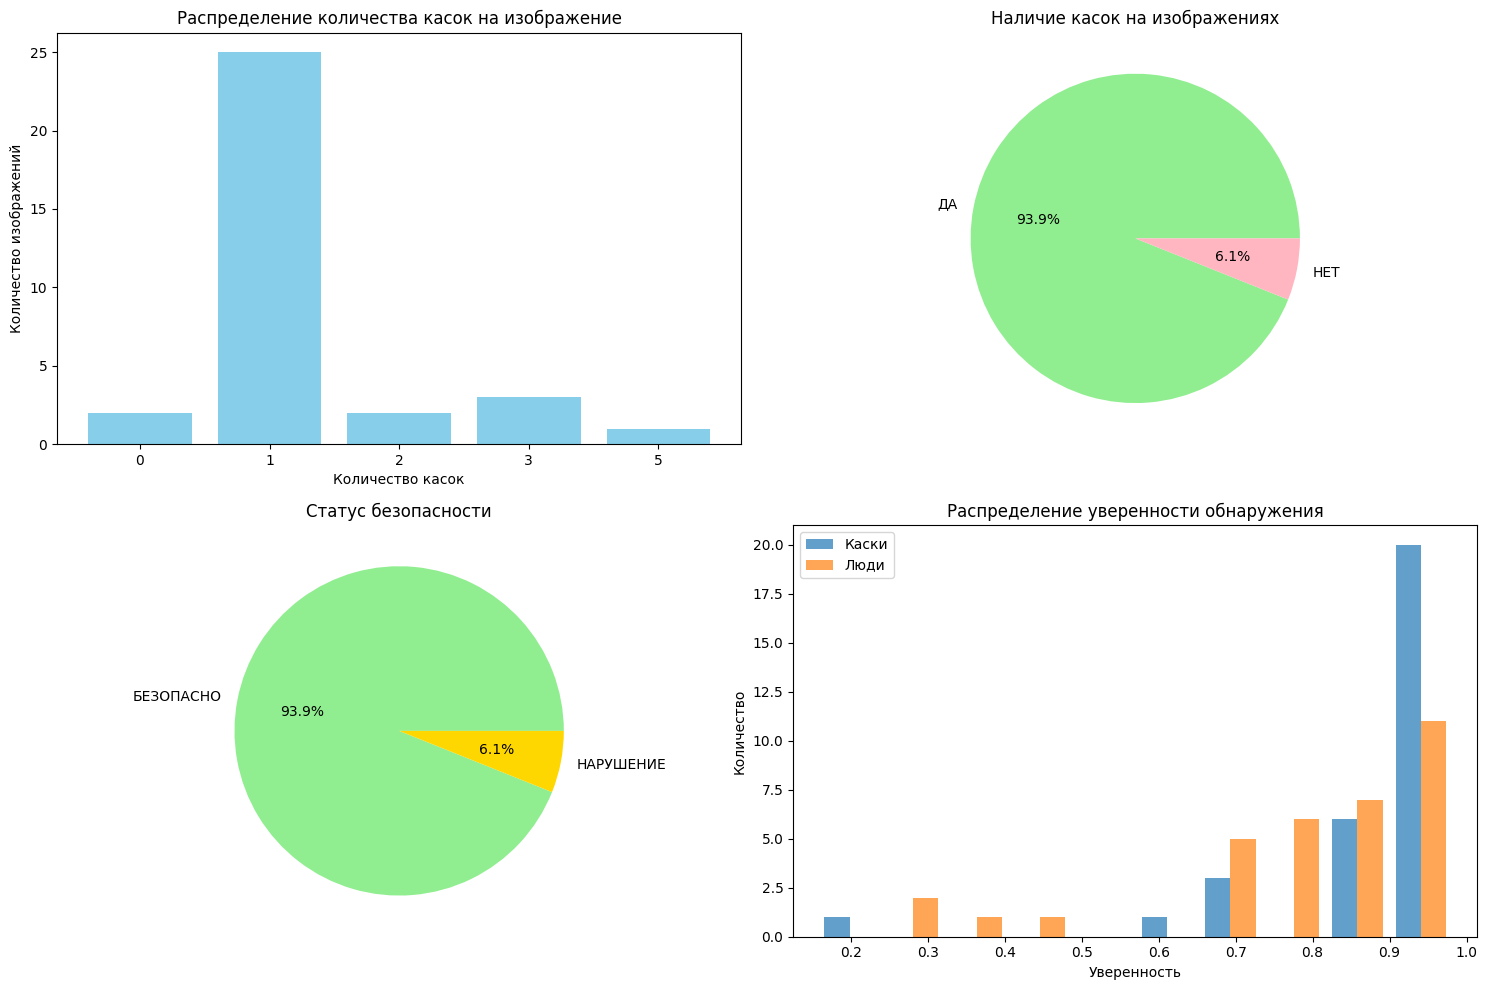


Визуализация графиков обучения...


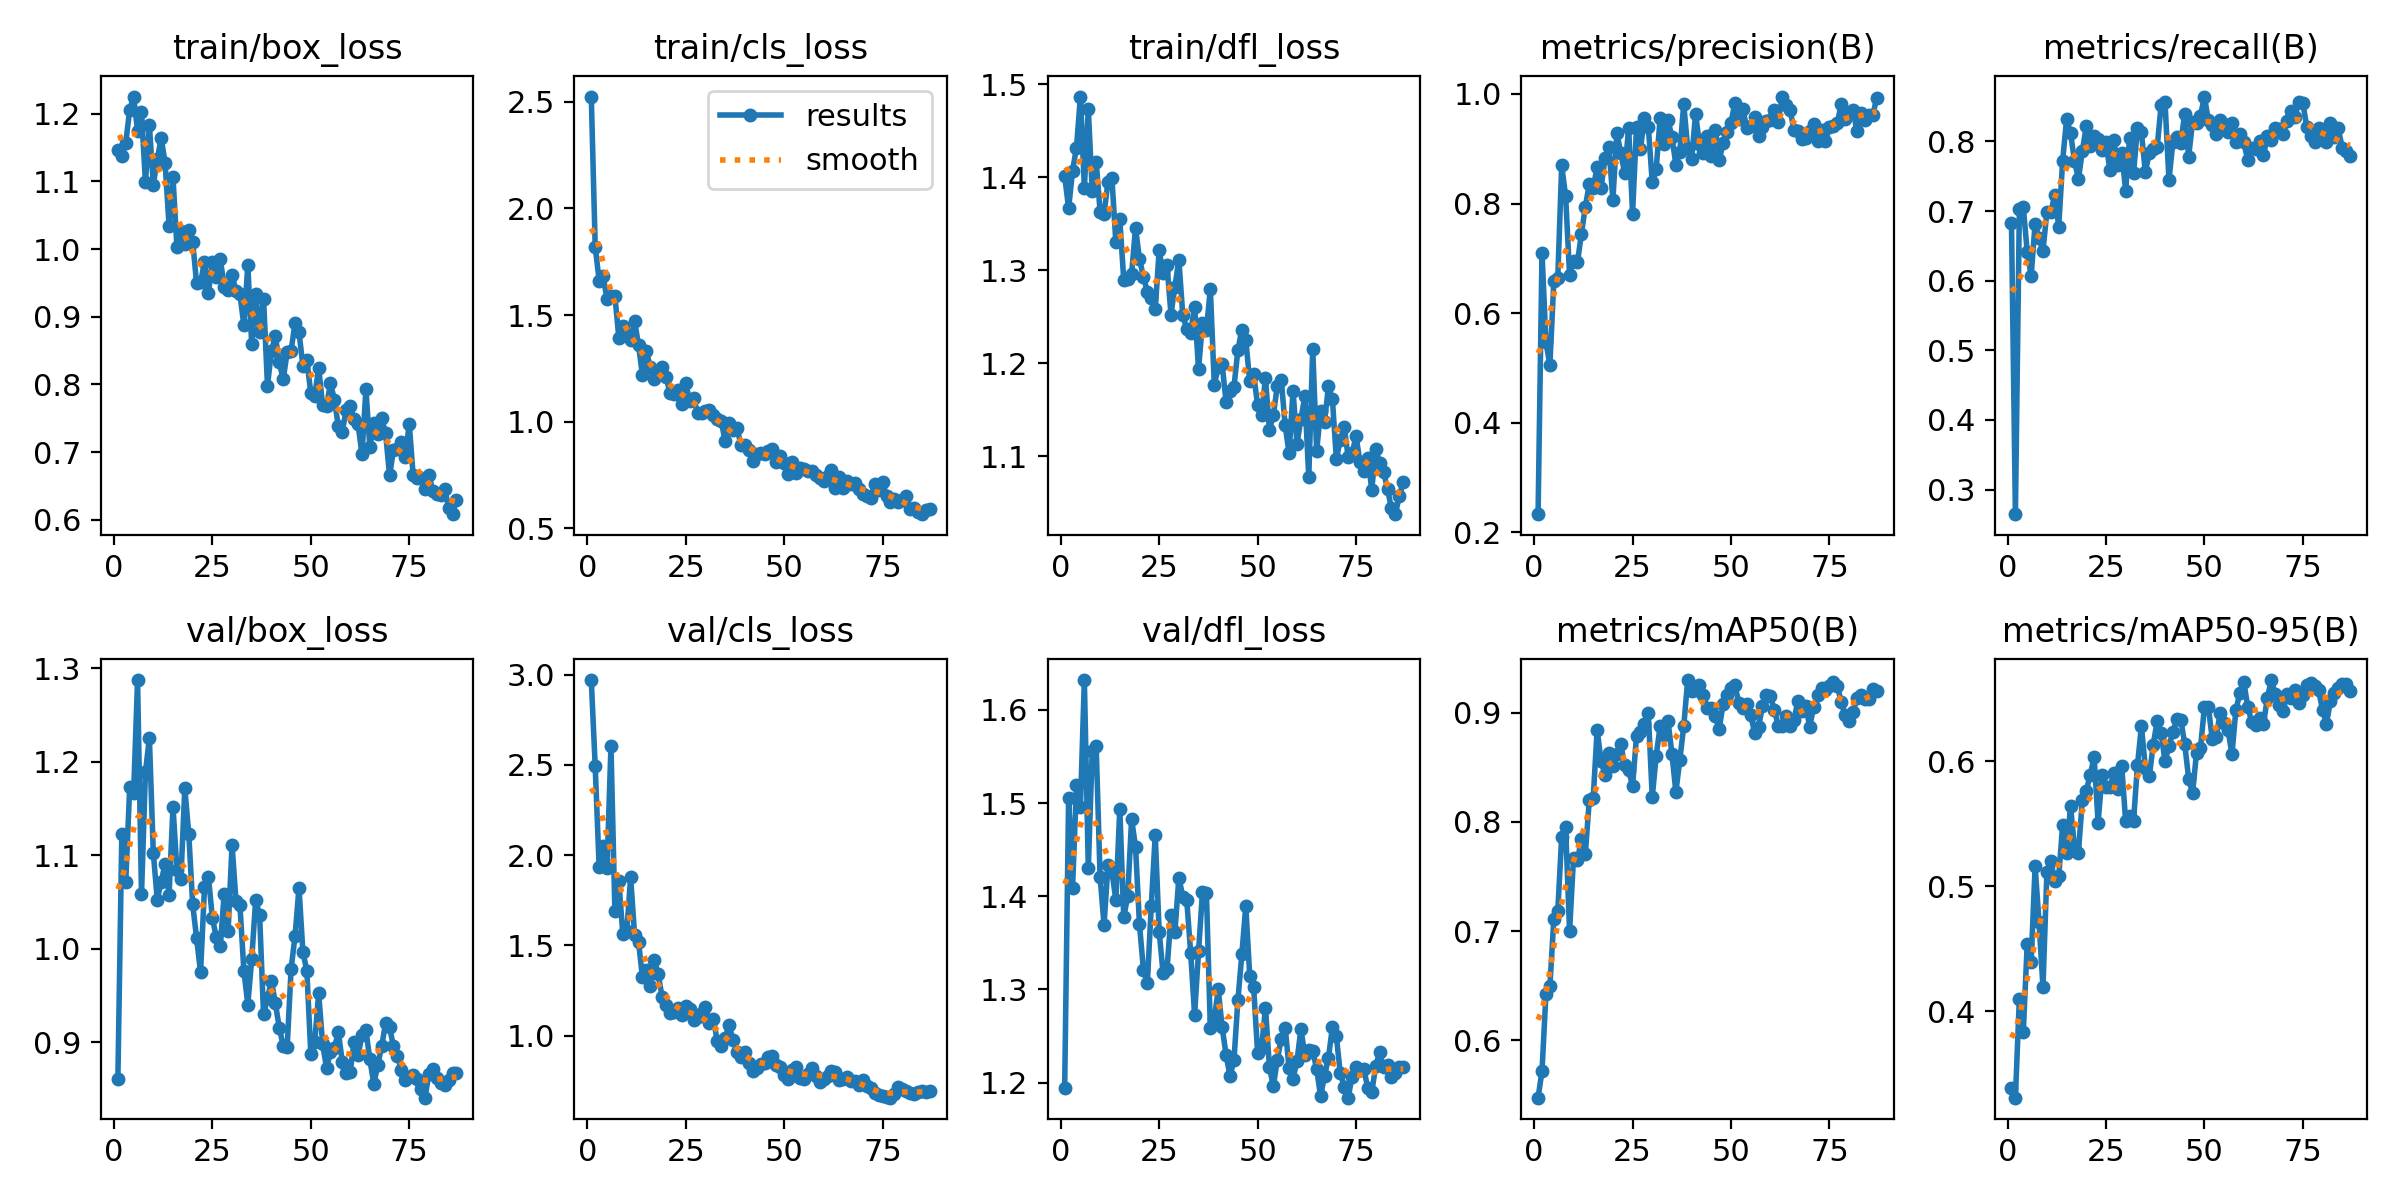

График: results.png


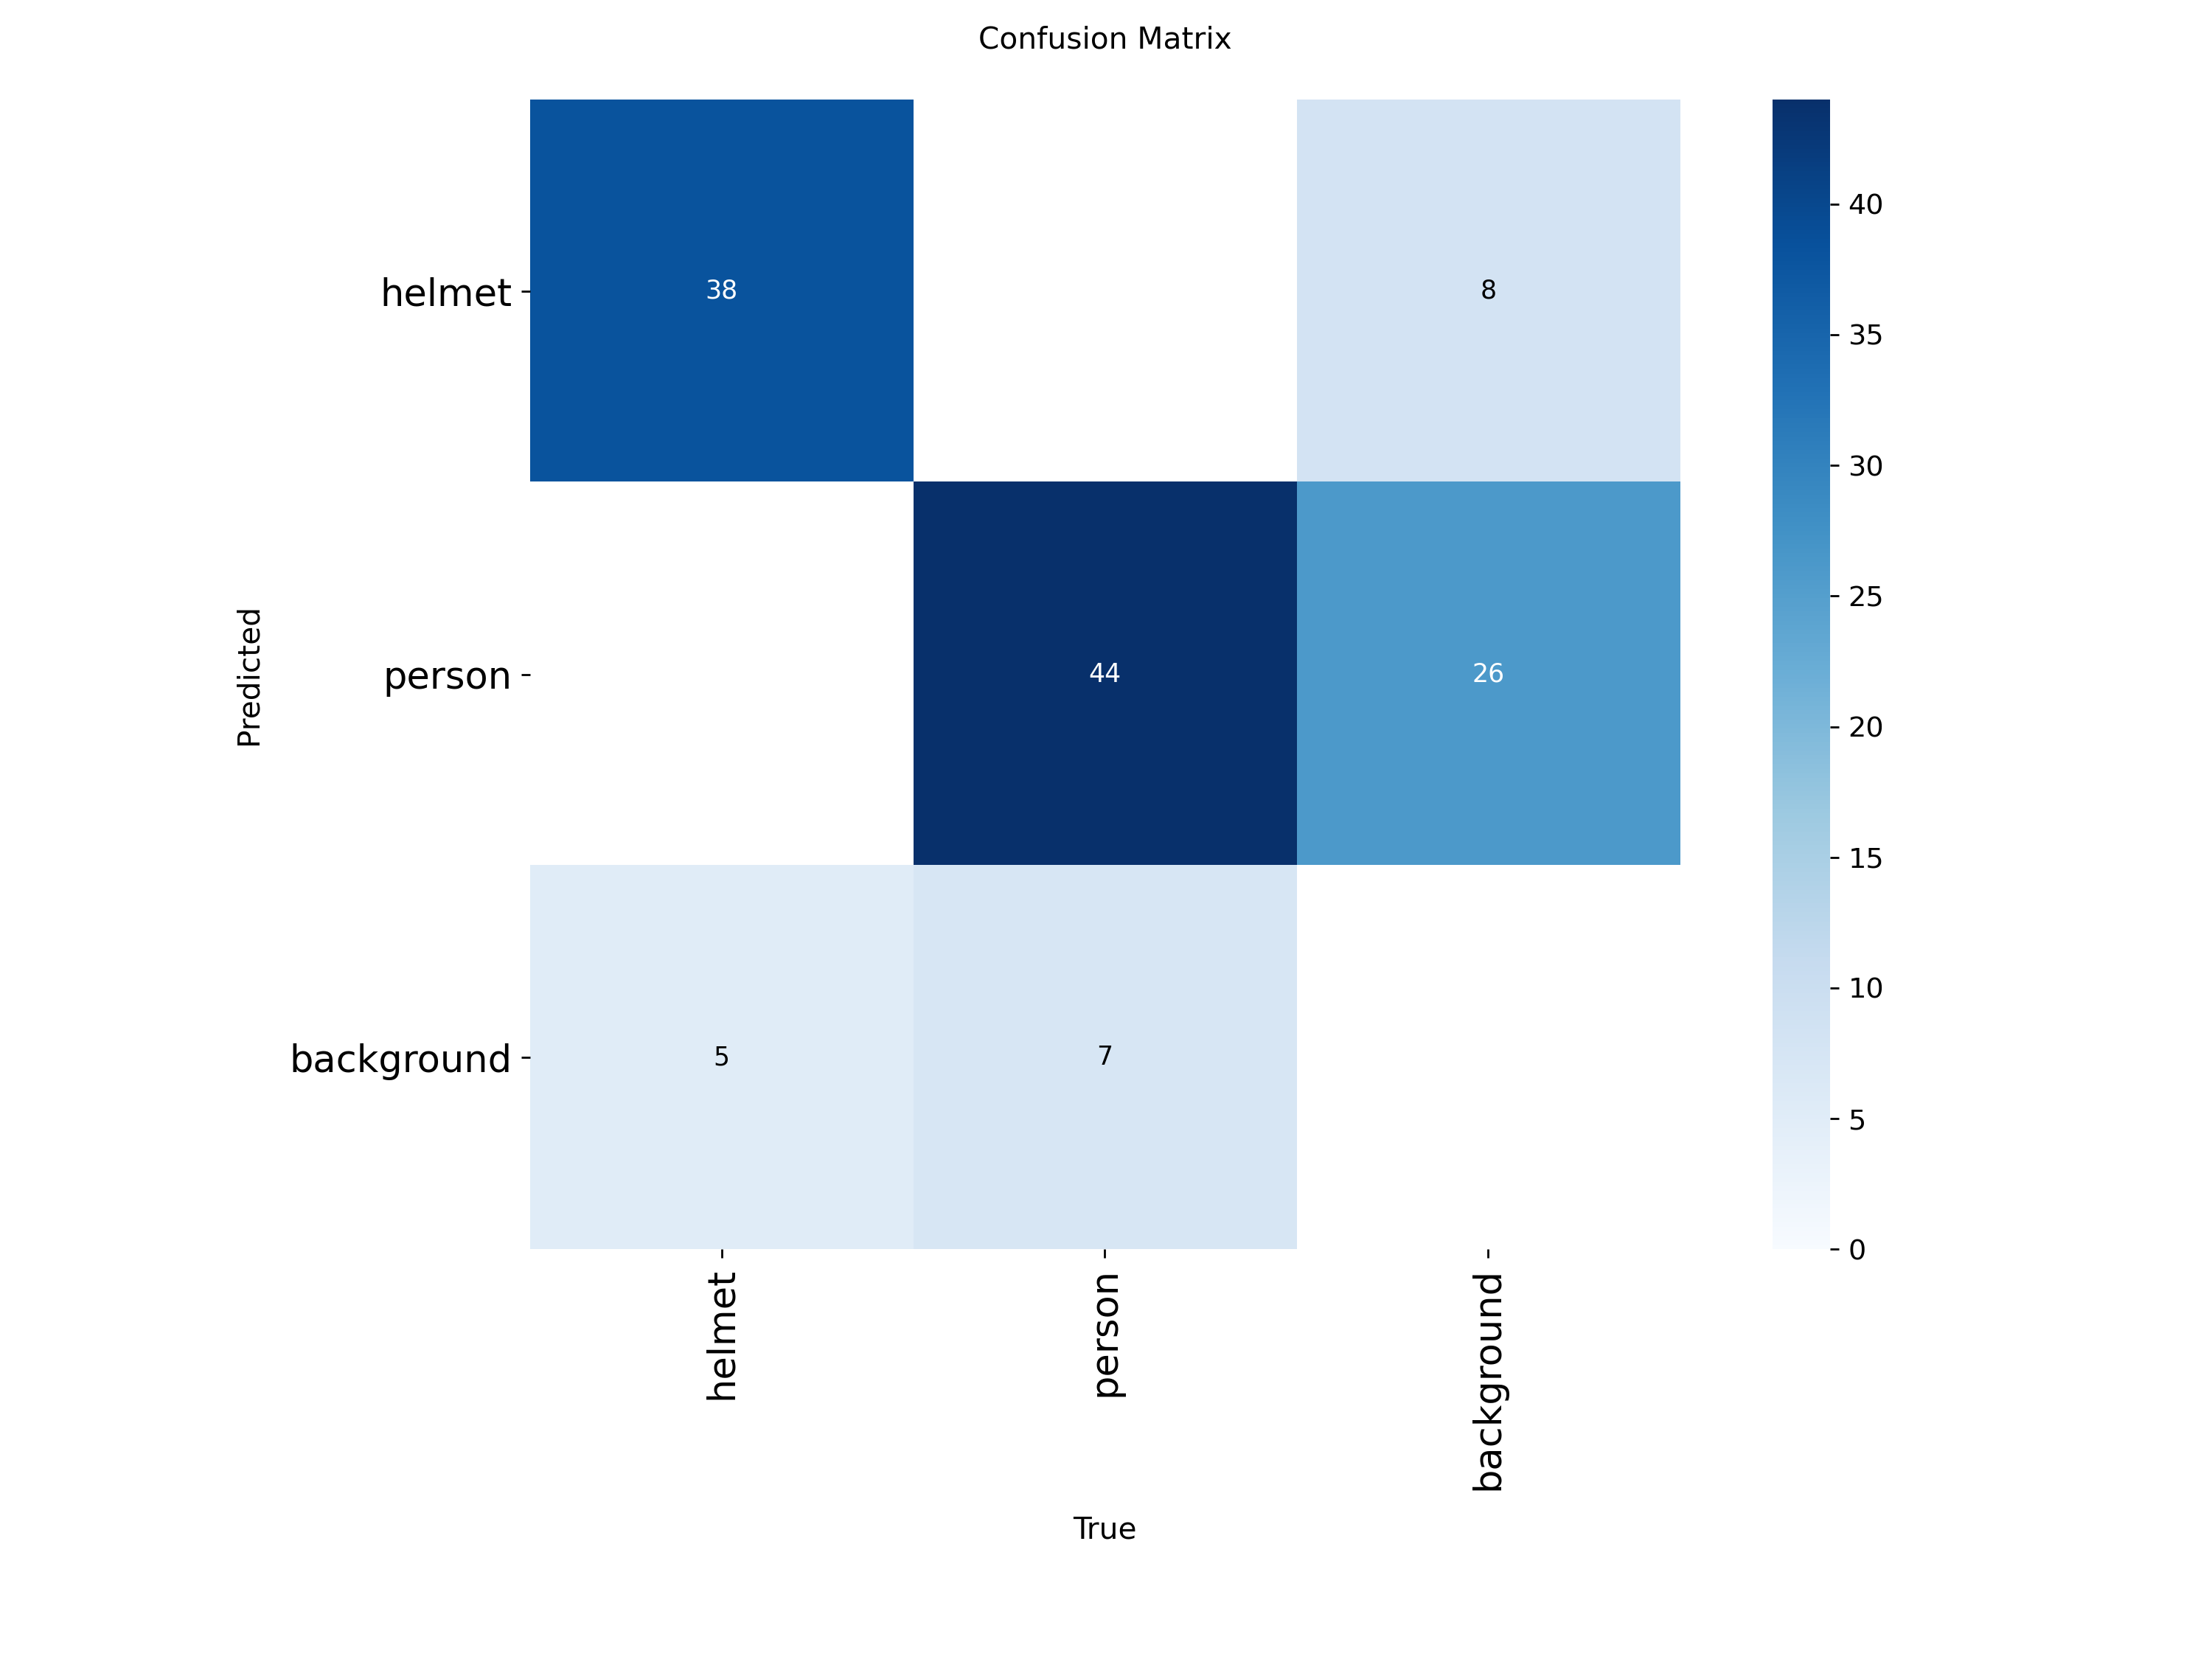

График: confusion_matrix.png
График F1_curve.png не найден
График P_curve.png не найден
График R_curve.png не найден

ДИАГНОСТИКА КАЧЕСТВА МОДЕЛИ
✅ Качество модели удовлетворительное (mAP@0.5: 0.911)


In [4]:
print("\n" + "="*60)
print("АНАЛИЗ ВСЕХ ВАЛИДАЦИОННЫХ ИЗОБРАЖЕНИЙ")
print("="*60)

val_images_dir = f"{final_dataset_path}/images/val"

if os.path.exists(val_images_dir):
    val_images = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Найдено валидационных изображений: {len(val_images)}")

    results_data = []

    for i, img_name in enumerate(val_images):
        img_path = os.path.join(val_images_dir, img_name)

        results = best_model.predict(
            source=img_path,
            conf=0.15,
            iou=0.4,
            device='cpu',
            verbose=False
        )

        helmets_found = 0
        persons_found = 0
        max_helmet_conf = 0
        max_person_conf = 0

        for r in results:
            boxes = r.boxes
            if boxes is not None and len(boxes) > 0:
                for box in boxes:
                    cls = int(box.cls)
                    conf = float(box.conf)
                    if cls == 0:  # helmet
                        helmets_found += 1
                        max_helmet_conf = max(max_helmet_conf, conf)
                    elif cls == 1:  # person
                        persons_found += 1
                        max_person_conf = max(max_person_conf, conf)

        if helmets_found > 0:
            status = "ДА"
            status_symbol = "[+]"
        else:
            status = "НЕТ"
            status_symbol = "[-]"

        if helmets_found > 0 and persons_found > 0:
            safety = "БЕЗОПАСНО"
            safety_symbol = "[OK]"
        elif helmets_found == 0 and persons_found > 0:
            safety = "НАРУШЕНИЕ"
            safety_symbol = "[!]"
        else:
            safety = "НЕТ ДАННЫХ"
            safety_symbol = "[?]"

        results_data.append({
            '№': i + 1,
            'Изображение': img_name,
            'Каски': helmets_found,
            'Люди': persons_found,
            'Статус': status,
            'Статус_символ': status_symbol,
            'Безопасность': safety,
            'Безопасность_символ': safety_symbol,
            'Макс. уверенность каски': f"{max_helmet_conf:.3f}" if max_helmet_conf > 0 else "0.000",
            'Макс. уверенность человека': f"{max_person_conf:.3f}" if max_person_conf > 0 else "0.000"
        })

        if (i + 1) % 5 == 0 or (i + 1) == len(val_images):
            print(f"Обработано {i + 1}/{len(val_images)} изображений...")

    df = pd.DataFrame(results_data)


    print("\n" + "="*80)
    print("ТАБЛИЦА РЕЗУЛЬТАТОВ АНАЛИЗА КАСОК")
    print("="*80)


    styled_df = df[['№', 'Изображение', 'Каски', 'Люди', 'Статус_символ', 'Безопасность_символ', 'Макс. уверенность каски']]\
        .rename(columns={
            'Статус_символ': 'Каска',
            'Безопасность_символ': 'Безопасность'
        })\
        .style\
        .applymap(lambda x: 'background-color: #90EE90' if x == '[ЕСТЬ]' else '', subset=['Каска'])\
        .applymap(lambda x: 'background-color: #FFB6C1' if x == '[НЕТ]' else '', subset=['Каска'])\
        .applymap(lambda x: 'background-color: #90EE90' if x == '[БЕЗОПАСНО]' else '', subset=['Безопасность'])\
        .applymap(lambda x: 'background-color: #FFD700' if x == '[НАРУШЕНИЕ]' else '', subset=['Безопасность'])\
        .applymap(lambda x: 'background-color: #E6E6FA' if x == '[?]' else '', subset=['Безопасность'])\
        .set_properties(**{'text-align': 'center'})

    display(styled_df)


    print("\n" + "="*80)
    print("СВОДНАЯ СТАТИСТИКА")
    print("="*80)

    total_images = len(df)
    images_with_helmets = len(df[df['Статус'] == 'ДА'])
    images_without_helmets = len(df[df['Статус'] == 'НЕТ'])
    violations = len(df[(df['Статус'] == 'НЕТ') & (df['Люди'] > 0)])

    print(f"Всего проанализировано изображений: {total_images}")
    print(f"Изображений с касками: {images_with_helmets} ({images_with_helmets/total_images*100:.1f}%)")
    print(f"Изображений без касок: {images_without_helmets} ({images_without_helmets/total_images*100:.1f}%)")
    print(f"Потенциальных нарушений безопасности: {violations} ({violations/total_images*100:.1f}%)")
    print(f"Общее количество обнаруженных касок: {df['Каски'].sum()}")
    print(f"Общее количество обнаруженных людей: {df['Люди'].sum()}")


    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))


    helmet_dist = df['Каски'].value_counts().sort_index()
    ax1.bar([str(x) for x in helmet_dist.index], helmet_dist.values, color='skyblue')
    ax1.set_title('Распределение количества касок на изображение')
    ax1.set_xlabel('Количество касок')
    ax1.set_ylabel('Количество изображений')


    status_counts = df['Статус'].value_counts()
    colors = ['#90EE90' if status == 'ДА' else '#FFB6C1' for status in status_counts.index]
    ax2.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', colors=colors)
    ax2.set_title('Наличие касок на изображениях')


    safety_counts = df['Безопасность'].value_counts()
    colors = ['#90EE90' if safety == 'БЕЗОПАСНО' else '#FFD700' if safety == 'НАРУШЕНИЕ' else 'lightgray' for safety in safety_counts.index]
    ax3.pie(safety_counts.values, labels=safety_counts.index, autopct='%1.1f%%', colors=colors)
    ax3.set_title('Статус безопасности')


    helmet_confs = pd.to_numeric(df['Макс. уверенность каски'])
    person_confs = pd.to_numeric(df['Макс. уверенность человека'])

    if len(helmet_confs[helmet_confs > 0]) > 0 or len(person_confs[person_confs > 0]) > 0:
        conf_data = []
        labels = []
        if len(helmet_confs[helmet_confs > 0]) > 0:
            conf_data.append(helmet_confs[helmet_confs > 0])
            labels.append('Каски')
        if len(person_confs[person_confs > 0]) > 0:
            conf_data.append(person_confs[person_confs > 0])
            labels.append('Люди')

        ax4.hist(conf_data, bins=10, alpha=0.7, label=labels)
        ax4.set_title('Распределение уверенности обнаружения')
        ax4.set_xlabel('Уверенность')
        ax4.set_ylabel('Количество')
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Нет данных об уверенности', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Распределение уверенности обнаружения')

    plt.tight_layout()
    plt.show()

else:
    print("Папка с валидационными изображениями не найдена!")


print("\nВизуализация графиков обучения...")

plots_path = '/content/runs/detect/train'
plot_files = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'P_curve.png', 'R_curve.png']

found_plots = False
for plot_file in plot_files:
    plot_path = os.path.join(plots_path, plot_file)
    if os.path.exists(plot_path):
        display(Image(filename=plot_path, width=800))
        print(f"График: {plot_file}")
        found_plots = True
    else:
        print(f"График {plot_file} не найден")

print("\n" + "="*60)
print("ДИАГНОСТИКА КАЧЕСТВА МОДЕЛИ")
print("="*60)

if 'metrics' in locals():
    map50 = metrics.box.map50
    if map50 < 0.3:
        print(f"⚠️  ВНИМАНИЕ: Низкое качество модели (mAP@0.5: {map50:.3f})")
        print("   Возможные причины:")
        print("   1. Недостаточно данных для обучения")
        print("   2. Слишком мало эпох обучения")
        print("   3. Проблемы с разметкой данных")
        print("   4. Слишком высокий порог уверенности")


        print("\n   Тестирование разных порогов уверенности:")
        test_image = val_images[0] if val_images else None
        if test_image:
            img_path = os.path.join(val_images_dir, test_image)
            for conf_threshold in [0.5, 0.3, 0.1, 0.05, 0.01]:
                test_results = best_model.predict(source=img_path, conf=conf_threshold, device='cpu', verbose=False)
                helmets = 0
                for r in test_results:
                    boxes = r.boxes
                    if boxes is not None:
                        for box in boxes:
                            if int(box.cls) == 0:
                                helmets += 1
                print(f"   Порог {conf_threshold}: {helmets} касок")
    else:
        print(f"✅ Качество модели удовлетворительное (mAP@0.5: {map50:.3f})")


ВИЗУАЛИЗАЦИЯ GT vs PRED + IoU


Изображение  Класс Уверенность    IoU
0  00007_jpg.rf.jpg      1        0.72  0.858
1  00007_jpg.rf.jpg      0        0.69  0.824
2  00007_jpg.rf.jpg      1        0.37  0.044

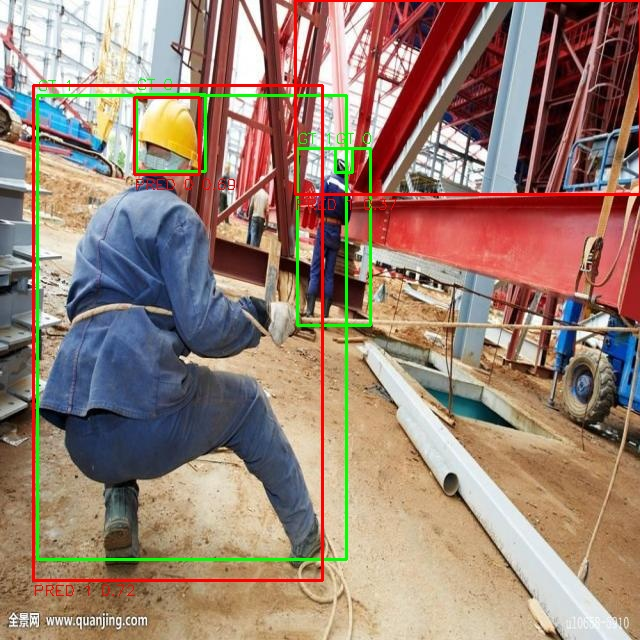

Изображение  Класс Уверенность    IoU
0  1191857680_jpg.rf.jpg      1        0.83  0.911

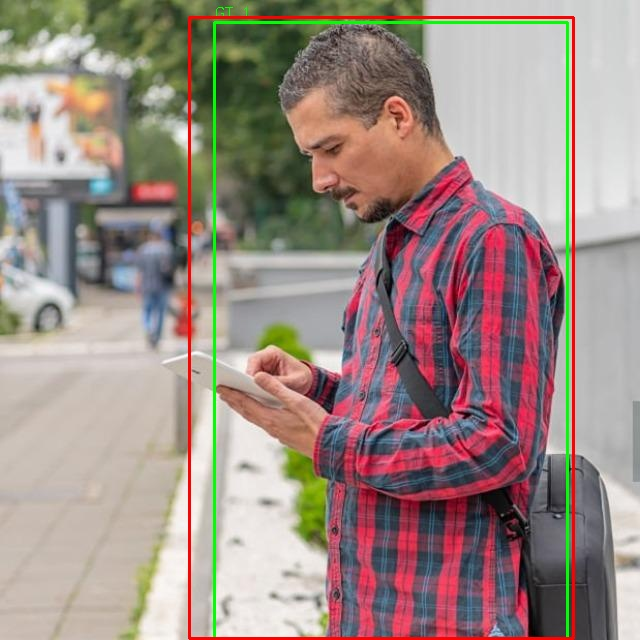

Изображение  Класс Уверенность    IoU
0  835468996_jpg.rf.jpg      1        0.96  0.883
1  835468996_jpg.rf.jpg      0        0.60  0.000

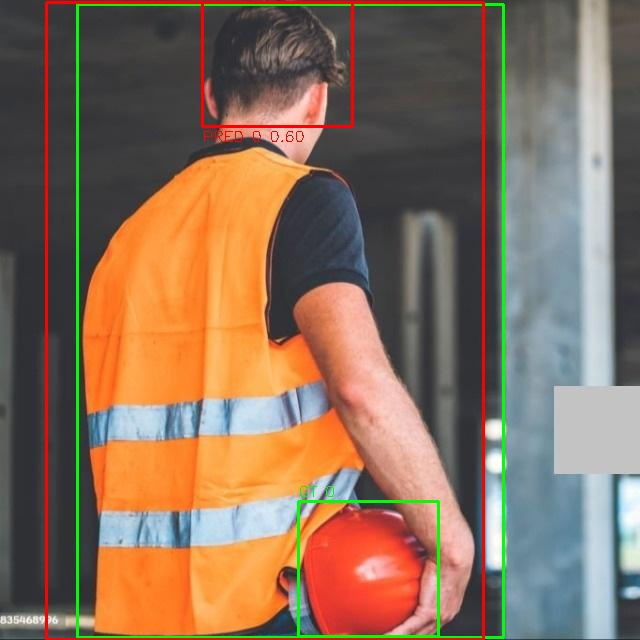

Изображение  Класс Уверенность    IoU
0  00129_jpg.rf.jpg      0        0.87  0.941
1  00129_jpg.rf.jpg      1        0.31  0.652

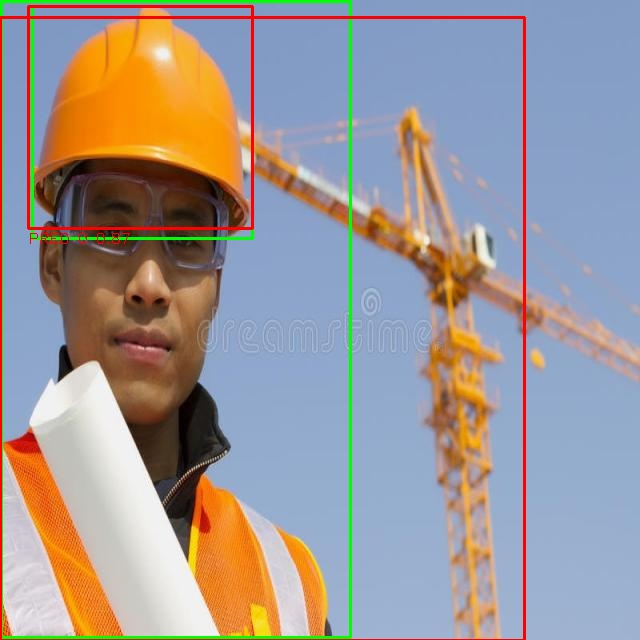

Изображение  Класс Уверенность    IoU
0  1313443607_jpg.rf.jpg      0        0.94  0.828
1  1313443607_jpg.rf.jpg      1        0.89  0.721

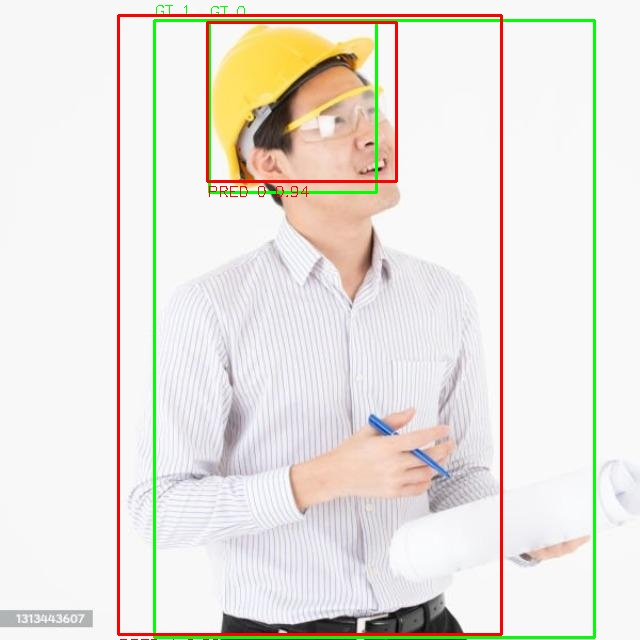

Изображение  Класс Уверенность    IoU
0  00079_jpg.rf.jpg      1        0.68  0.525
1  00079_jpg.rf.jpg      0        0.67  0.908

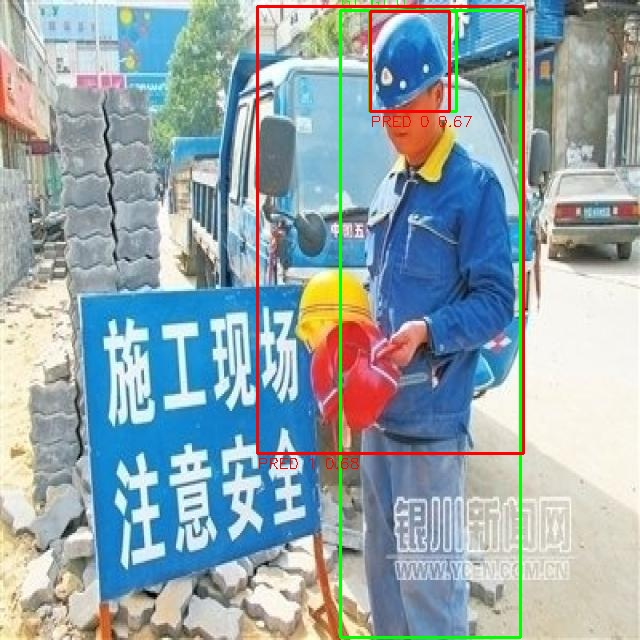

Изображение  Класс Уверенность    IoU
0  00100_jpg.rf.jpg      0        0.90  0.644
1  00100_jpg.rf.jpg      1        0.69  0.856
2  00100_jpg.rf.jpg      1        0.48  0.000
3  00100_jpg.rf.jpg      0        0.46  0.000
4  00100_jpg.rf.jpg      1        0.43  0.246

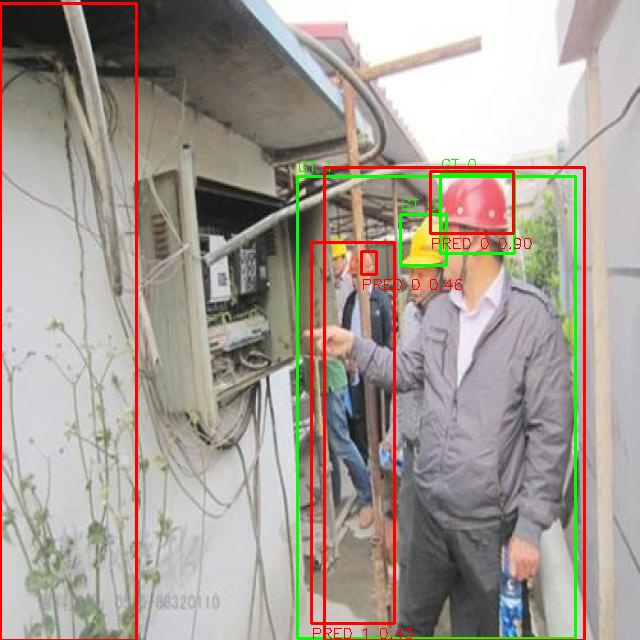

Изображение  Класс Уверенность    IoU
0  00004_jpg.rf.jpg      0        0.96  0.908
1  00004_jpg.rf.jpg      1        0.91  0.822
2  00004_jpg.rf.jpg      1        0.51  0.942
3  00004_jpg.rf.jpg      1        0.29  0.000

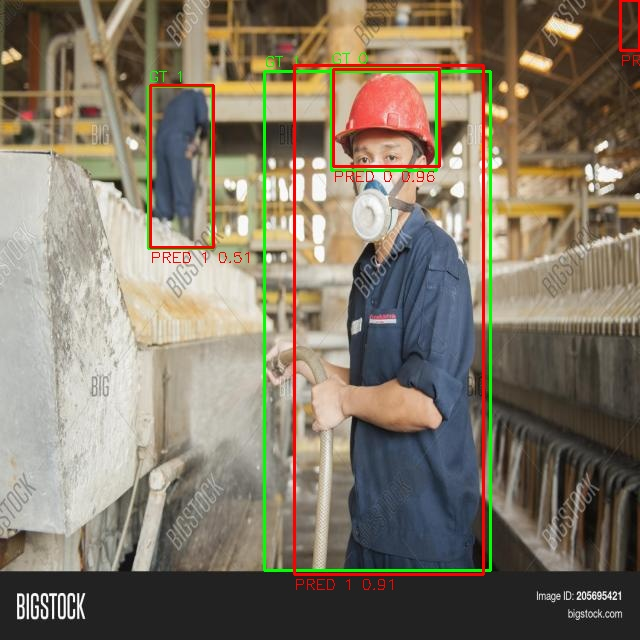

Изображение  Класс Уверенность    IoU
0  1650229546_jpg.rf.jpg      0        0.90  0.913
1  1650229546_jpg.rf.jpg      1        0.89  0.964
2  1650229546_jpg.rf.jpg      0        0.87  0.922
3  1650229546_jpg.rf.jpg      0        0.87  0.837
4  1650229546_jpg.rf.jpg      1        0.84  0.875
5  1650229546_jpg.rf.jpg      1        0.76  0.905

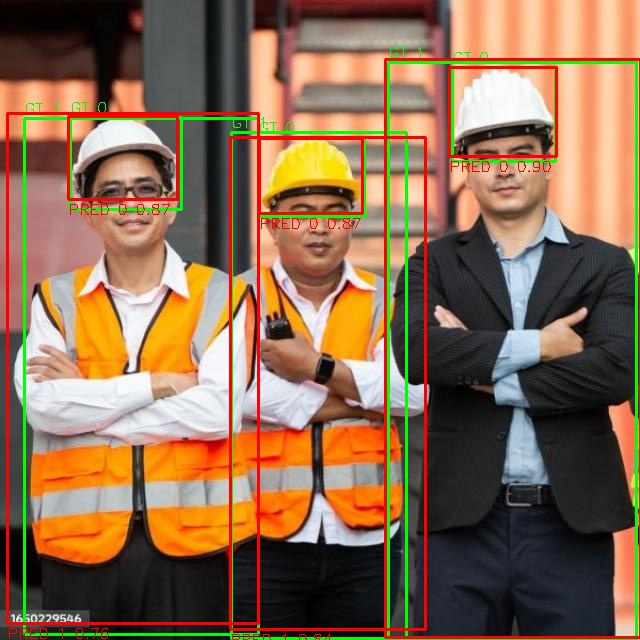

Изображение  Класс Уверенность    IoU
0  00235_jpg.rf.jpg      1        0.77  0.959
1  00235_jpg.rf.jpg      1        0.69  0.554
2  00235_jpg.rf.jpg      1        0.61  0.859

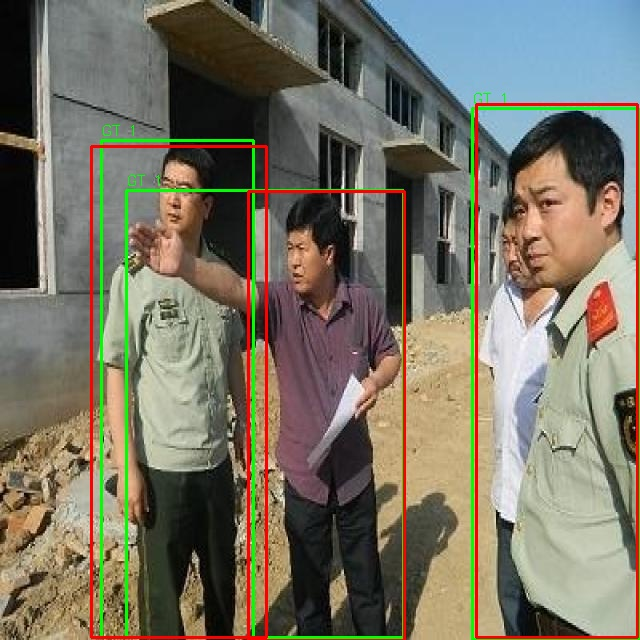

Изображение  Класс Уверенность    IoU
0  00034_jpg.rf.jpg      0        0.87  0.772
1  00034_jpg.rf.jpg      1        0.68  0.877
2  00034_jpg.rf.jpg      1        0.65  0.000

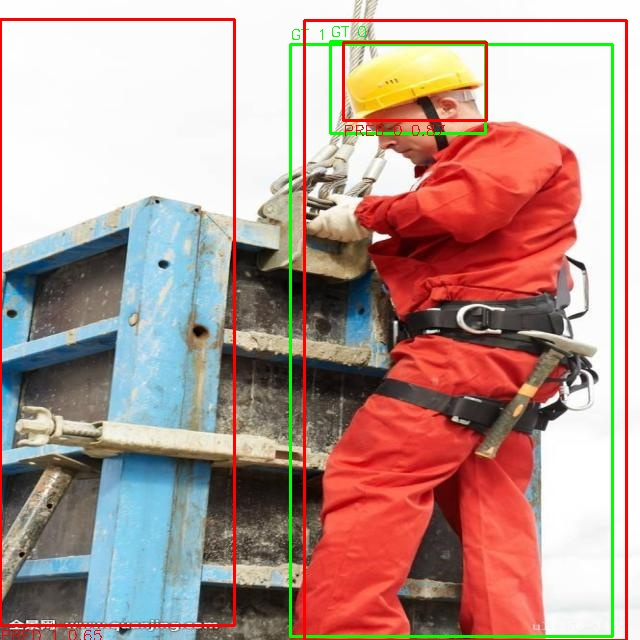

Изображение  Класс Уверенность    IoU
0  00022_jpg.rf.jpg      0        0.94  0.916
1  00022_jpg.rf.jpg      1        0.90  0.957

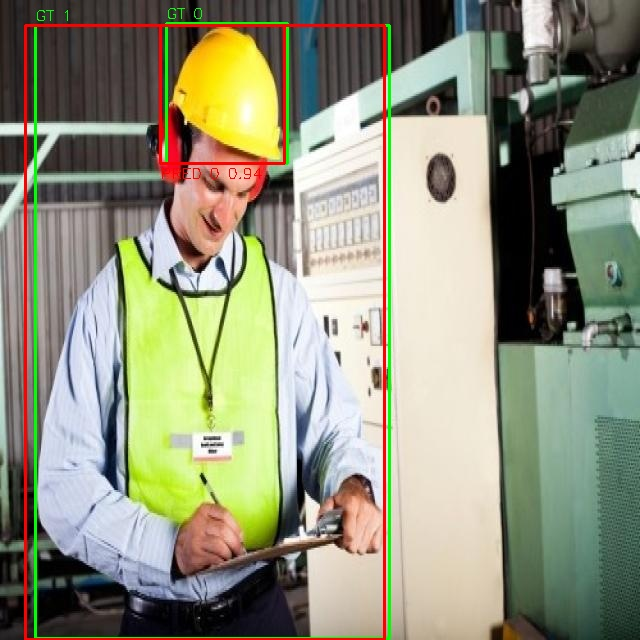

Изображение  Класс Уверенность    IoU
0  00169_jpg.rf.jpg      0        0.89  0.898
1  00169_jpg.rf.jpg      1        0.78  0.835
2  00169_jpg.rf.jpg      0        0.77  0.838
3  00169_jpg.rf.jpg      1        0.61  0.832

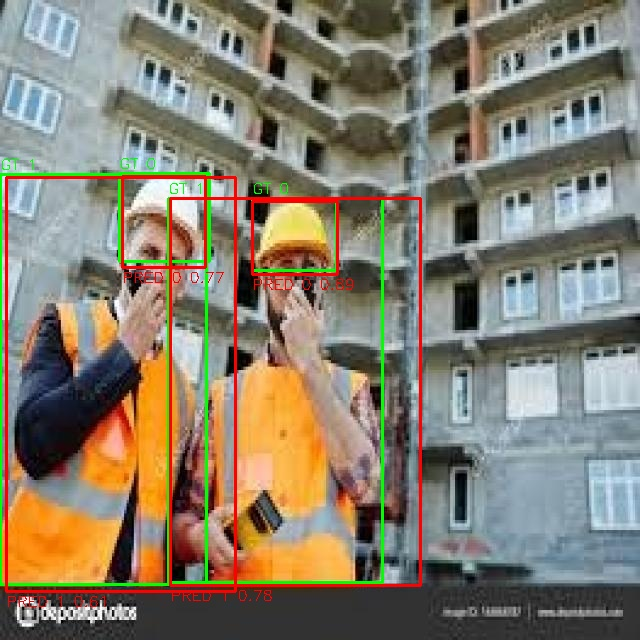

Изображение  Класс Уверенность    IoU
0  948675786-_jpg.rf.jpg      0        0.95  0.893
1  948675786-_jpg.rf.jpg      1        0.80  0.762

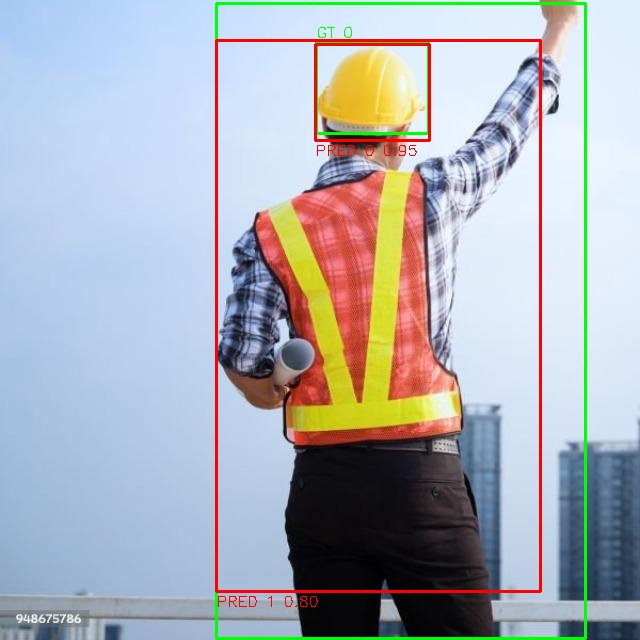

Изображение  Класс Уверенность    IoU
0  00226_jpg.rf.jpg      0        0.94  0.917
1  00226_jpg.rf.jpg      1        0.89  0.878

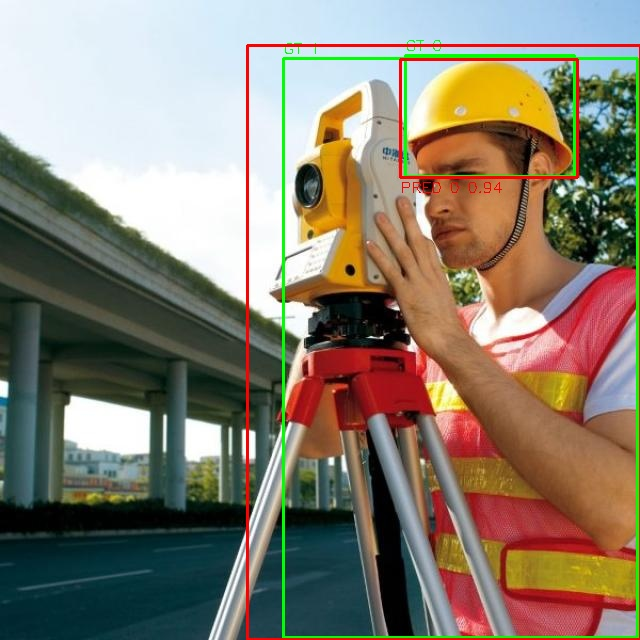

Изображение  Класс Уверенность    IoU
0  03256_jpg.rf.jpg      0        0.86  0.848
1  03256_jpg.rf.jpg      1        0.34  0.279
2  03256_jpg.rf.jpg      1        0.30  0.710

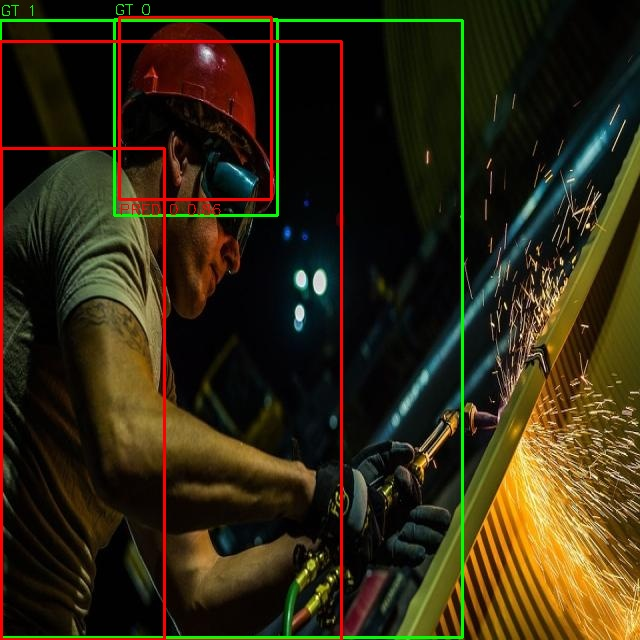

Изображение  Класс Уверенность    IoU
0  03411_jpg.rf.jpg      0        0.70  0.935
1  03411_jpg.rf.jpg      1        0.27  0.635

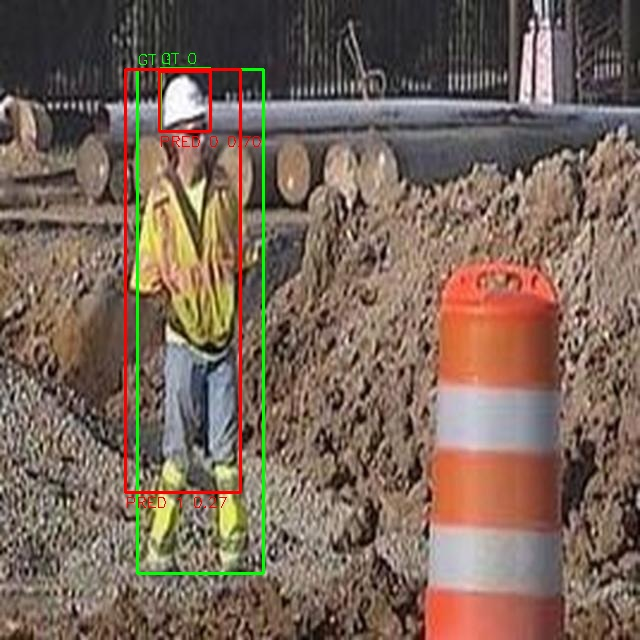

Изображение  Класс Уверенность    IoU
0  1326894686_jpg.rf.jpg      0        0.98  0.961
1  1326894686_jpg.rf.jpg      1        0.95  0.905

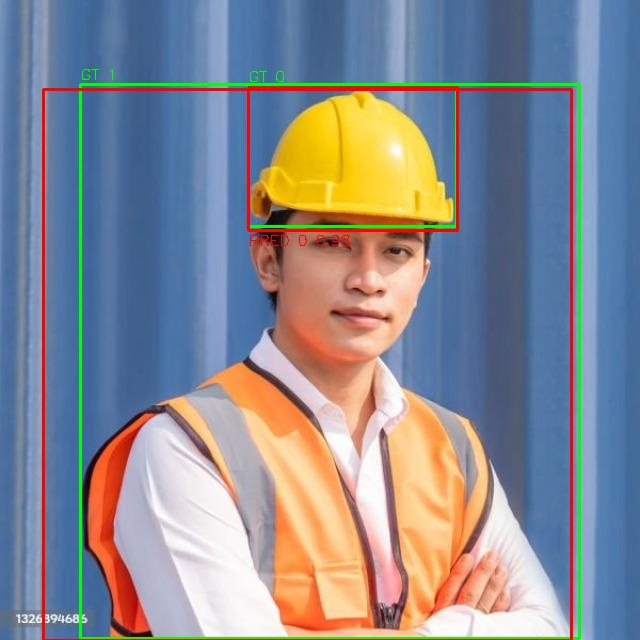

Изображение  Класс Уверенность    IoU
0  1398225569_jpg.rf.jpg      1        0.95  0.940
1  1398225569_jpg.rf.jpg      0        0.94  0.970
2  1398225569_jpg.rf.jpg      1        0.49  0.018

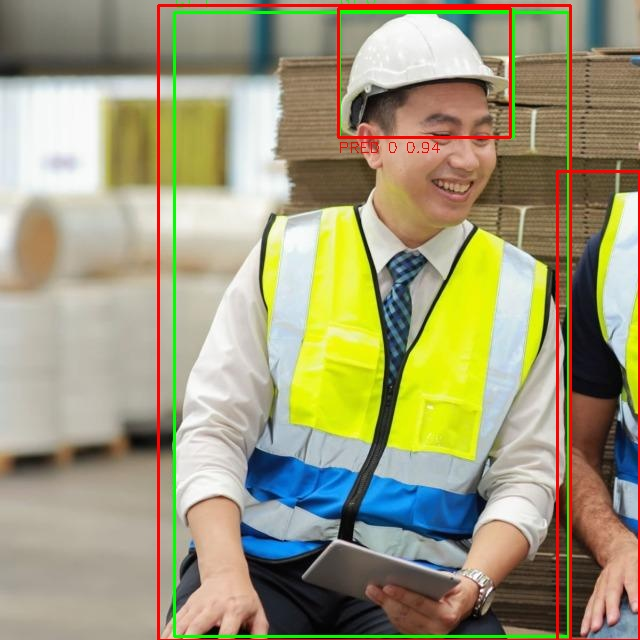

Изображение  Класс Уверенность    IoU
0  955657420_jpg.rf.jpg      1        0.95  0.976
1  955657420_jpg.rf.jpg      0        0.92  0.957

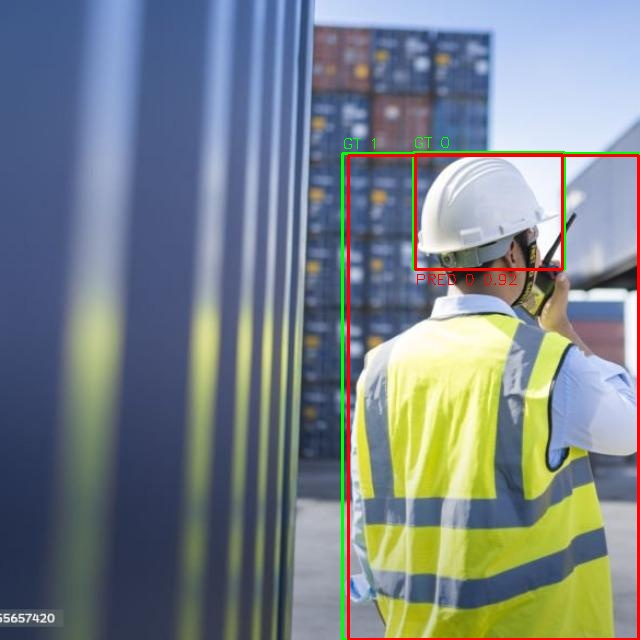

Изображение  Класс Уверенность    IoU
0  1405230315_jpg.rf.jpg      1        0.97  0.991
1  1405230315_jpg.rf.jpg      0        0.96  0.970

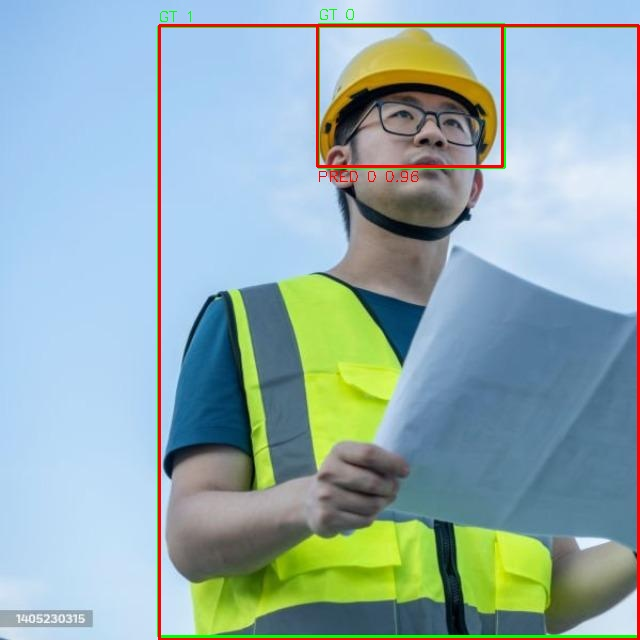

Изображение  Класс Уверенность    IoU
0  1299859712_jpg.rf.jpg      1        0.48  0.606
1  1299859712_jpg.rf.jpg      1        0.27  0.295

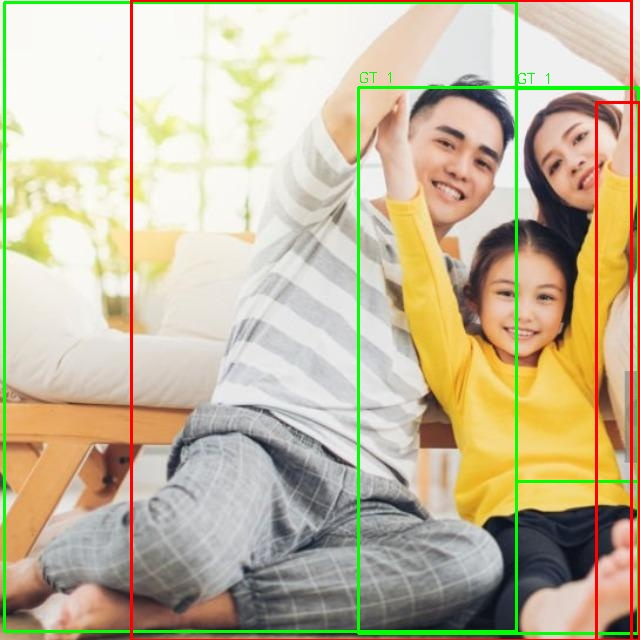

Изображение  Класс Уверенность    IoU
0  1203370400_jpg.rf.jpg      0        0.93  0.961
1  1203370400_jpg.rf.jpg      1        0.79  0.659
2  1203370400_jpg.rf.jpg      1        0.53  0.456

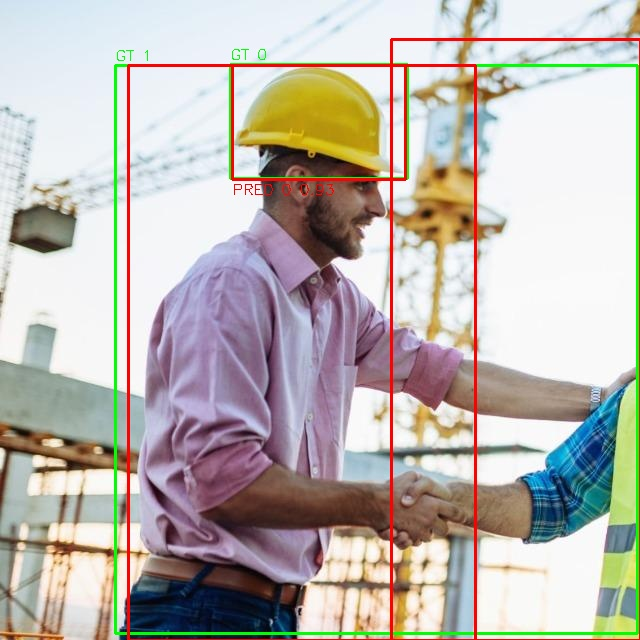

Изображение  Класс Уверенность    IoU
0  1475620570_jpg.rf.jpg      0        0.95  0.961
1  1475620570_jpg.rf.jpg      1        0.90  0.952

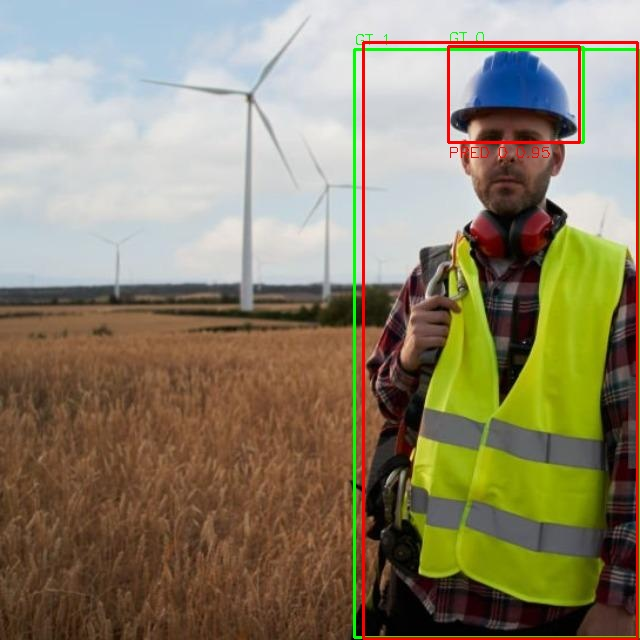

Изображение  Класс Уверенность    IoU
0  00065_jpg.rf.jpg      0        0.98  0.964
1  00065_jpg.rf.jpg      1        0.73  0.949

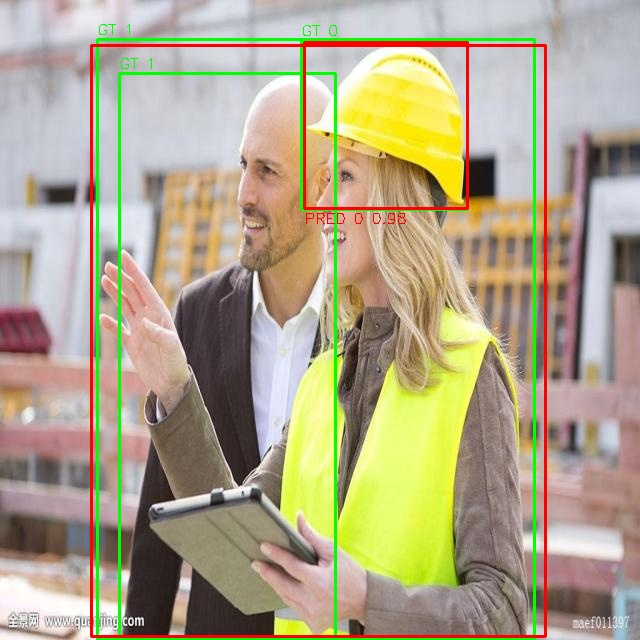

Изображение  Класс Уверенность    IoU
0  4287056_s_jpg.rf.jpg      0        0.96  0.908
1  4287056_s_jpg.rf.jpg      1        0.92  0.895

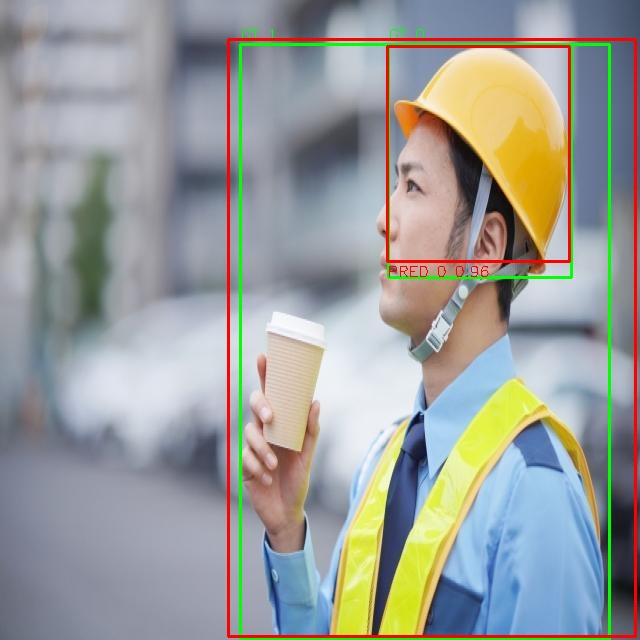

Изображение  Класс Уверенность    IoU
0  1491516161_jpg.rf.jpg      0        0.96  0.881
1  1491516161_jpg.rf.jpg      1        0.87  0.940

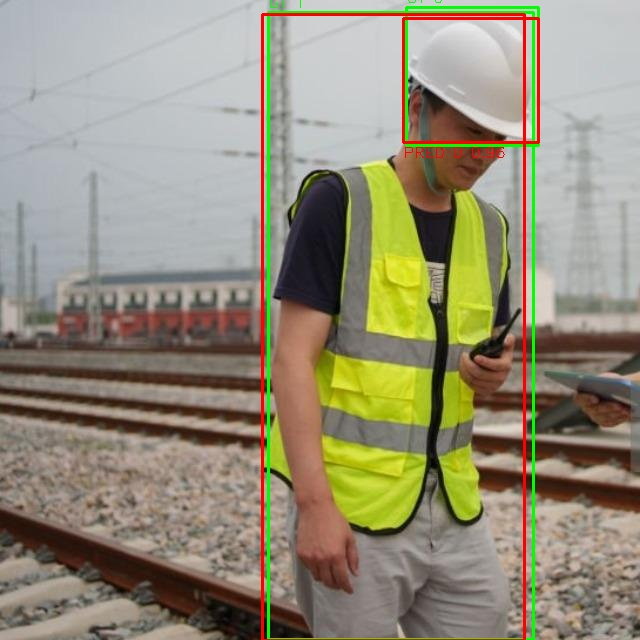

Изображение  Класс Уверенность    IoU
0  1301229589_jpg.rf.jpg      0        0.94  0.939
1  1301229589_jpg.rf.jpg      1        0.76  0.940

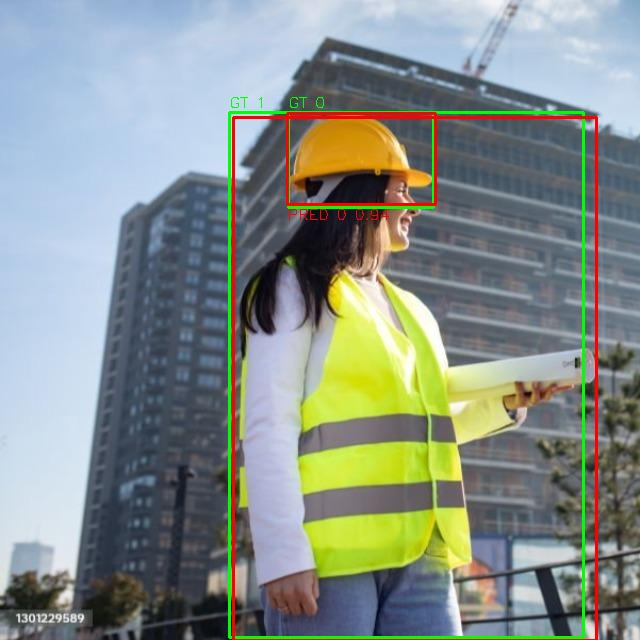

Изображение  Класс Уверенность    IoU
0  1265647993_jpg.rf.jpg      0        0.96  0.937
1  1265647993_jpg.rf.jpg      1        0.82  0.986

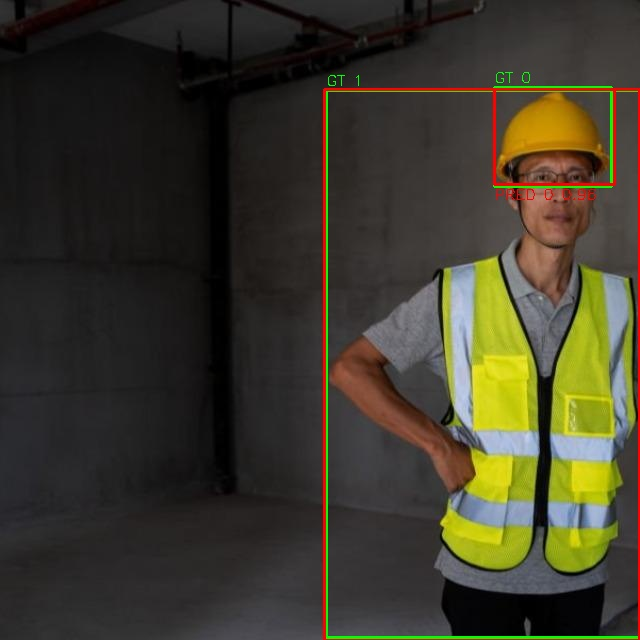

Изображение  Класс Уверенность    IoU
0  1448068640-_jpg.rf.jpg      0        0.95  0.946
1  1448068640-_jpg.rf.jpg      0        0.95  0.928
2  1448068640-_jpg.rf.jpg      1        0.92  0.977
3  1448068640-_jpg.rf.jpg      1        0.91  0.954
4  1448068640-_jpg.rf.jpg      0        0.68  0.000

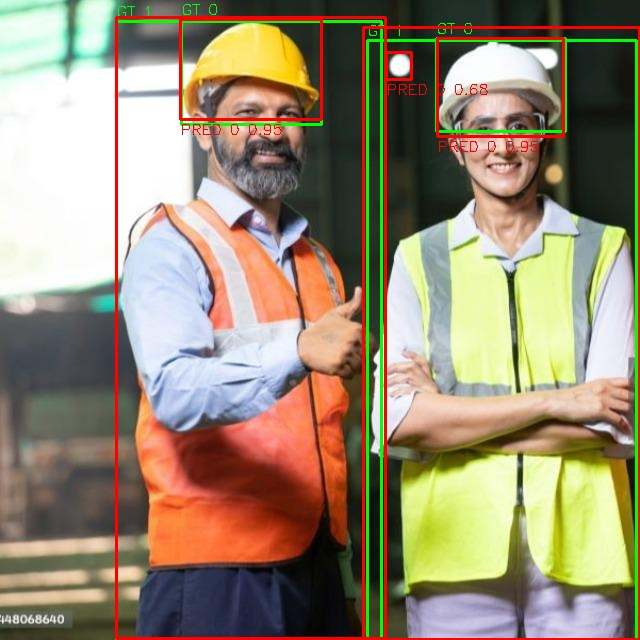

Изображение  Класс Уверенность    IoU
0  00152_jpg.rf.jpg      1        0.93  0.911
1  00152_jpg.rf.jpg      0        0.92  0.705
2  00152_jpg.rf.jpg      0        0.91  0.888
3  00152_jpg.rf.jpg      1        0.90  0.664
4  00152_jpg.rf.jpg      1        0.25  0.000

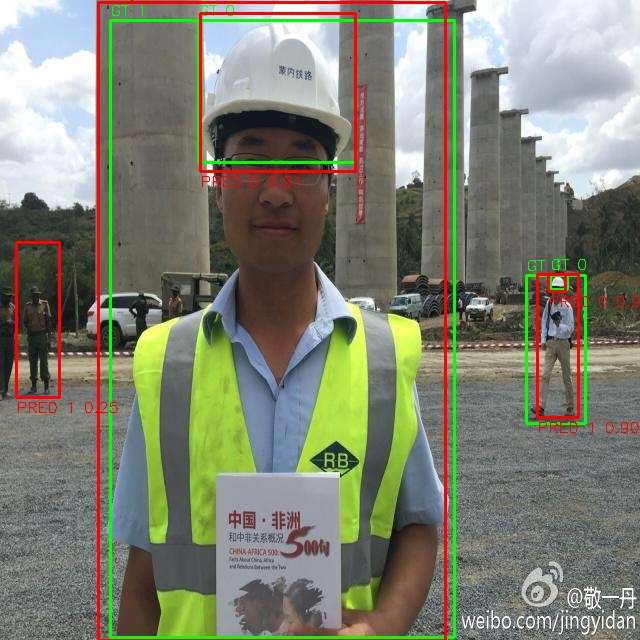

Изображение  Класс Уверенность    IoU
0  4287047_s_jpg.rf.jpg      1        0.88  0.939
1  4287047_s_jpg.rf.jpg      0        0.87  0.900
2  4287047_s_jpg.rf.jpg      1        0.29  0.088

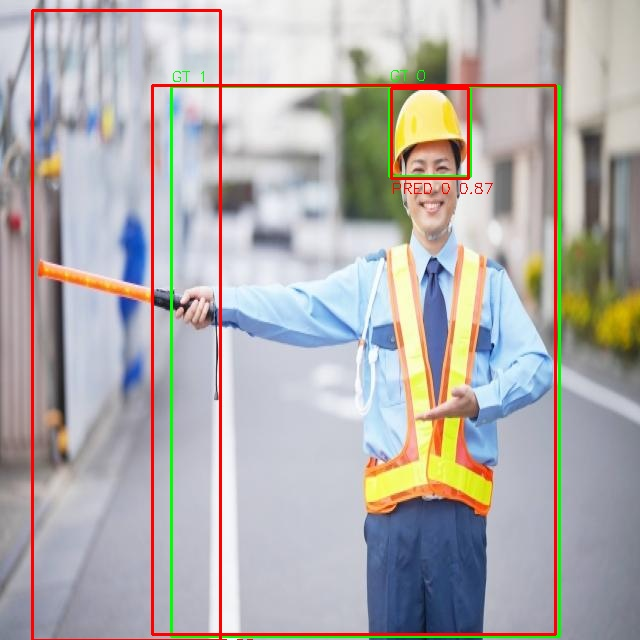

Изображение  Класс Уверенность    IoU
0  03253_jpg.rf.jpg      0        0.97  0.858
1  03253_jpg.rf.jpg      0        0.96  0.839
2  03253_jpg.rf.jpg      1        0.81  0.782
3  03253_jpg.rf.jpg      0        0.74  0.873
4  03253_jpg.rf.jpg      1        0.32  0.404
5  03253_jpg.rf.jpg      1        0.27  0.738
6  03253_jpg.rf.jpg      0        0.26  0.596

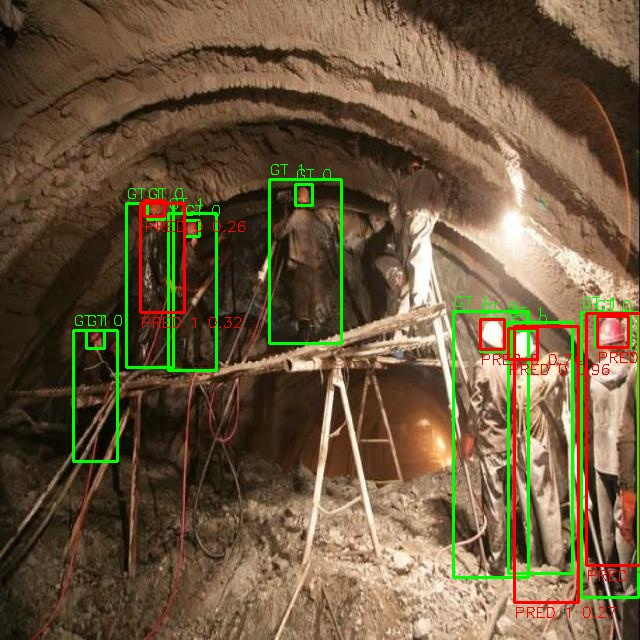


СТАТИСТИКА ПО IoU
Средний IoU по выборке: 0.745
Медианный IoU: 0.877
Минимальный IoU: 0.000
Максимальный IoU: 0.991


In [12]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import display, Image

def calculate_iou(box1, box2):
    # box = [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0.0
    return inter_area / union_area

print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ GT vs PRED + IoU")
print("="*60)

labels_dir = f"{final_dataset_path}/labels/val"
output_vis_dir = "/content/val_visualization"
os.makedirs(output_vis_dir, exist_ok=True)

all_ious = []

for img_name in val_images:
    img_path = os.path.join(val_images_dir, img_name)
    label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + ".txt")

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    rows = []


    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                gx1 = int((x - bw/2) * w)
                gy1 = int((y - bh/2) * h)
                gx2 = int((x + bw/2) * w)
                gy2 = int((y + bh/2) * h)
                gt_boxes.append((int(cls), [gx1, gy1, gx2, gy2]))
                cv2.rectangle(img, (gx1, gy1), (gx2, gy2), (0, 255, 0), 2)
                cv2.putText(img, f"GT {int(cls)}", (gx1, gy1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)


    results = best_model.predict(source=img_path, conf=0.25, iou=0.4, device="cpu", verbose=False)
    for r in results:
        for box in r.boxes:
            pred_box = list(map(int, box.xyxy[0].cpu().numpy()))
            conf = float(box.conf)
            cls = int(box.cls)

            cv2.rectangle(img, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (0, 0, 255), 2)
            cv2.putText(img, f"PRED {cls} {conf:.2f}", (pred_box[0], pred_box[3] + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

            iou_for_this_pred = 0.0
            for gt_cls, gt_box in gt_boxes:
                if gt_cls == cls:
                    iou = calculate_iou(pred_box, gt_box)
                    iou_for_this_pred = max(iou_for_this_pred, iou)
            rows.append({"Изображение": img_name, "Класс": cls, "Уверенность": f"{conf:.2f}", "IoU": f"{iou_for_this_pred:.3f}"})
            all_ious.append(iou_for_this_pred)


    out_path = os.path.join(output_vis_dir, img_name)
    cv2.imwrite(out_path, img)

    if rows:
        df = pd.DataFrame(rows)
        display(df)
    display(Image(filename=out_path))

print("\n" + "="*60)
print("СТАТИСТИКА ПО IoU")
print("="*60)
if all_ious:
    print(f"Средний IoU по выборке: {np.mean(all_ious):.3f}")
    print(f"Медианный IoU: {np.median(all_ious):.3f}")
    print(f"Минимальный IoU: {np.min(all_ious):.3f}")
    print(f"Максимальный IoU: {np.max(all_ious):.3f}")
